In [5]:
import numpy as np
import pandas as pd
from biom import load_table
from gneiss.util import match
from deicode.optspace import OptSpace
from deicode.preprocessing import rclr
from IPython.core.display import HTML
#plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
plt.rcParams["axes.labelsize"] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
%matplotlib inline

In [6]:
#fix font-size
HTML("""<style>div.cell { /* Tunes the space between cells */margin-top:1em;margin-bottom:1em;}div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 3em;line-height:1.4em;text-align:center;}
div.text_cell_render h2 { /*  Parts names nearer from text */margin-bottom: -0.4em;}
div.text_cell_render { /* Customize text cells */font-family: 'Times New Roman';font-size:1.8em;line-height:1.4em;
padding-left:3em;padding-right:3em;}</style>""")

First, we will import the table and metadata

In [7]:
# import the biom table
table = load_table('qiita_10422_table.biom')
# import taxa
taxa = pd.read_table('taxonomy.tsv', index_col=0)
# import the metadata
meta = pd.read_table('qiita_10422_metadata.tsv', index_col=0)

# filter sample to min depth
def sample_filter(val, id_, md): return sum(val) > 500
def observation_filter(val, id_, md): return sum(val) > 10
table = table.filter(sample_filter, axis='sample')
table = table.filter(observation_filter, axis='observation')

# ensure index matches
table,taxa = match(table.to_dataframe(),taxa)
table,meta = match(table.T,meta)

# rename table otus
table.columns=['sOTU'+str(i) for i in range(len(table.columns))]
taxa['sequence'] = taxa.index
taxa.index = table.columns

#view table
table.head(5)

,sOTU0,sOTU1,sOTU2,sOTU3,sOTU4,sOTU5,sOTU6,sOTU7,sOTU8,sOTU9,...,sOTU599,sOTU600,sOTU601,sOTU602,sOTU603,sOTU604,sOTU605,sOTU606,sOTU607,sOTU608
10422.21.F.7,0.0,0.0,0.0,0.0,140.0,11.0,0.0,0.0,106.0,0.0,...,481.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10422.26.F.11,0.0,0.0,0.0,0.0,150.0,1.0,0.0,0.0,0.0,0.0,...,305.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10422.19.F.9,0.0,0.0,0.0,0.0,955.0,24.0,0.0,0.0,126.0,0.0,...,40.0,0.0,0.0,143.0,0.0,0.0,0.0,0.0,0.0,0.0
10422.27.F.13,0.0,0.0,0.0,0.0,460.0,0.0,0.0,0.0,4.0,0.0,...,497.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10422.29.F.11,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,...,166.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, we will run the rclr transform and RPCA



In [8]:
#rclr 
table_rclr=rclr().fit_transform(table)

# OptSpace (RPCA)
opt=OptSpace(rank=3).fit(table_rclr)
U=opt.sample_weights # numpy.ndarray - "Sample Loadings" 
V=opt.feature_weights # numpy.ndarray - "Feature Loadings" 
s=opt.s # numpy.ndarray - The singular values

# save loadings as dataframes
sample_rankings = pd.DataFrame(opt.sample_weights,
                               index=table.index,
                               columns=['PC1','PC2','PC3'])

feature_rankings = pd.DataFrame(opt.feature_weights,
                                index=table.columns,
                                columns=['PC1','PC2','PC3']).sort_values('PC2')

feature_rankings.head(5)

,PC1,PC2,PC3
sOTU273,-1.153384,-3.594111,1.411954
sOTU217,1.184402,-3.171598,2.747444
sOTU4,1.695170,-3.081742,1.394286
sOTU232,1.614621,-2.845901,-0.800186
sOTU296,0.214348,-2.717329,-1.074596


Next, we will plot our conventional ordination plot using the PC1 and PC2 axis in sample loadings.



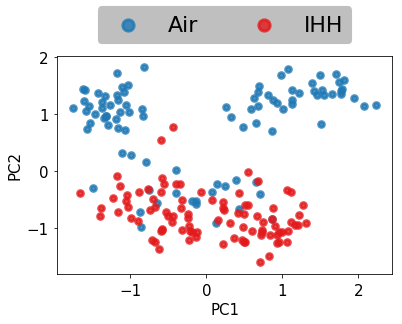

In [9]:
fig,ax = plt.subplots()

colors_map=['#1f78b4','#e31a1c']
classes=np.sort(list(set(meta.exposure_type.values)))
for sub_class,color_ in zip(classes,colors_map):
    idx = meta.exposure_type == sub_class        
    ax.scatter(sample_rankings.loc[idx, sample_rankings.columns[0]],
       sample_rankings.loc[idx, sample_rankings.columns[1]], 
       label=sub_class.replace('stressed','Stressed'),
       facecolors=color_,
       edgecolors=color_,
       alpha=.8,linewidth=3) 
ax.set_xlabel(sample_rankings.columns[0],fontsize=15)
ax.set_ylabel(sample_rankings.columns[1],fontsize=15)
plt.legend(loc='upper center', 
                bbox_to_anchor=(0.5, 1.28),
                prop={'size':22},
                fancybox=True, framealpha=0.5,ncol=2
                , markerscale=2, facecolor="grey")
plt.show()

Now we can look at the log ratios of the high-loaded features along PC2. We will call the largest positive loading $x_i$ and the the largest negative loading $y_i$. This can only be done for samples who do not have zeros in either $x_i$ or $y_i$.

Note: The variation between IHH and Air is along PC2 here so we will need to use the feature loadings from PC2.

In [10]:

x_i = feature_rankings.index[0]
y_i = feature_rankings.index[-1]

lrdf = table[table[[x_i,y_i]].T.min()>0]
lrdf = pd.DataFrame(np.log(lrdf.loc[:,x_i])-np.log(lrdf.loc[:,y_i]), 
                    columns=['$log(\dfrac{'+x_i+'}{'+y_i+'})$'])

lrdf.head(5)

,$log(\dfrac{sOTU273}{sOTU128})$
10422.26.F.11,-4.786511
10422.27.F.13,0.209229
10422.29.F.11,-4.936409
10422.27.F.7,-6.894163
10422.22.F.13,5.304548


Now we will combine this with metadata and the PC1 from the sample loadings to plot.



In [11]:
# merge 
lrdf = pd.concat([lrdf,sample_rankings,meta[['exposure_type']]],axis=1).dropna()
# view
lrdf.head(5)


,$log(\dfrac{sOTU273}{sOTU128})$,PC1,PC2,PC3,exposure_type
10422.17.F.10,3.555348,0.666141,-0.781473,1.131213,IHH
10422.17.F.13,5.602119,0.229238,-0.688088,1.136050,IHH
10422.17.F.4,4.922896,0.957254,-1.242962,1.063683,IHH
10422.17.F.7,3.951244,1.170595,-0.952217,1.105984,IHH
10422.17.F.8,4.812184,1.207802,-0.949669,1.132583,IHH


Now we can plot the scatter plot with taxonomic meaning on the x-axis and the conventional PC2 on the y-axis.



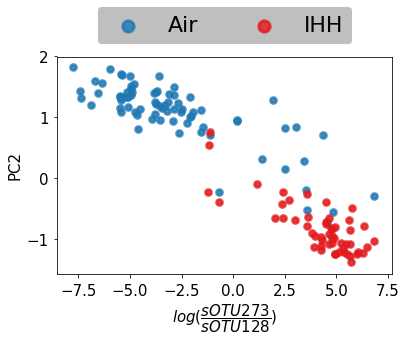

In [12]:
fig,ax = plt.subplots()

colors_map=['#1f78b4','#e31a1c']
classes=np.sort(list(set(lrdf.exposure_type.values)))
for sub_class,color_ in zip(classes,colors_map):
    idx = lrdf.exposure_type == sub_class        
    ax.scatter(lrdf.loc[idx, lrdf.columns[0]],
       lrdf.loc[idx, lrdf.columns[2]], 
       label=sub_class,
       facecolors=color_,
       edgecolors=color_,
       alpha=.8,linewidth=3) 
ax.set_xlabel(lrdf.columns[0],fontsize=15)
ax.set_ylabel(lrdf.columns[2],fontsize=15)
plt.legend(loc='upper center', 
                bbox_to_anchor=(0.5, 1.28),
                prop={'size':22},
                fancybox=True, framealpha=0.5,ncol=2
                , markerscale=2, facecolor="grey")
plt.show()

In [14]:
taxa.loc[[x_i,y_i]].T

,sOTU273,sOTU128
Taxon,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,k__Bacteria; p__Actinobacteria; c__Coriobacter...
Confidence,0.734537,0.929315
sequence,TACGTAGGGAGCGAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...,TACGTAGGGGGCGAGCGTTATCCGGATTCATTGGGCGTAAAGCGCG...


From the taxonomy table we can pull out the assignment of these two sOTUS. We can see that they belong to the family Ruminococcaceae and Coriobacteriaceae. We see that Ruminococcaceae (numerator) increased relative to Coriobacteriaceae (denominator).